In [1]:
import torch
import os, sys, time, struct, json, dill as pickle
from os.path import join as pj
from collections import defaultdict
import numpy as np, scipy, sklearn

In [2]:
%matplotlib notebook

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
BASE_LOG_DIR="/tmp/stephan/logs/multires/group2"

In [5]:
%load_ext autoreload
%autoreload 2

In [102]:
from results_utils import *

In [57]:
from collections import defaultdict

## Fetch folders for each run

In [125]:
def get_session_fp(EXP, blacklist, whitelist):
  sessions = []
  
  for i in os.walk(BASE_LOG_DIR):
    if all([k in i[0] for k in whitelist + [EXP]]):
      if not any([k in i[0] for k in blacklist]):
        if "run_1" in i[1]: #  "ckpt" in i[1] and "monitor" in i[1]:                                 
          sessions += [i[0]]
          print(i[0])          
  return sessions

sessions_by_exp = {}

# ["10-11-17"] # ["10-08-17_20-33-42"] # ["10-07-17_16-08-11"]
blacklist = [] # ["fvf"] 

whitelist = ["200000_", "10-12-17", "parafac", "bb"] 
# "group1", ["10-11-17"] # ["10-08-17_20-33-42"] # ["10-07-17_16-08-11"]

SELECTED_EXPS = []
SELECTED_EXPS += ["ent_div"]
SELECTED_EXPS += ["loss_conv"]
SELECTED_EXPS += ["mu_sd"]
SELECTED_EXPS += ["sd_div"]
SELECTED_EXPS += ["multires"]
SELECTED_EXPS += ["fixedres"]

for e in SELECTED_EXPS:
  sessions_by_exp[e] = get_session_fp(e, blacklist, whitelist)  

/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-25-32
/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-36-47
/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-30-38
/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-27-04
/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-31-22
/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_19-32-59
/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_15-07-27
/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-25-05
/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-10-53
/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_con

# Load data

In [126]:
res_all_exps = {}
for e, sess_fp in sessions_by_exp.items():  
  res_all_exps[e] = get_data_from_sessions(sess_fp, verbose=True)

Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-25-32/run_1
Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-36-47/run_3
Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-36-47/run_1
Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-36-47/run_2
Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-30-38/run_1
Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-27-04/run_1
Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-31-22/run_3
Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-31-22/run_1


Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-36-47/run_1
Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-36-47/run_2
Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-30-38/run_1
Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-27-04/run_1
Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-31-22/run_3
Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-31-22/run_1
Loading data from /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-31-22/run_2


# Select which runs to plot

In [127]:
for exp, res_all_sessions in res_all_exps.items():    
  for k, res in res_all_sessions.items():    
    select_res(res)

## Plot all runs for exps: copy fp of runs to include

In [128]:
# data, model, exp, list of xy pairs
keep_data = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: None))))

In [129]:
figs = []


# fvf, full

# fvf, parafac

# bb, full


# bb, parafac
keep_fp = [
  "/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-26-34/run_3",
  "/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-26-34/run_1",
  "/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-20-20/run_1",

  "/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-36-47/run_3",
  
  "/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/sd_div/10-12-17_21-27-06/run_5",
  
]

<IPython.core.display.Javascript object>


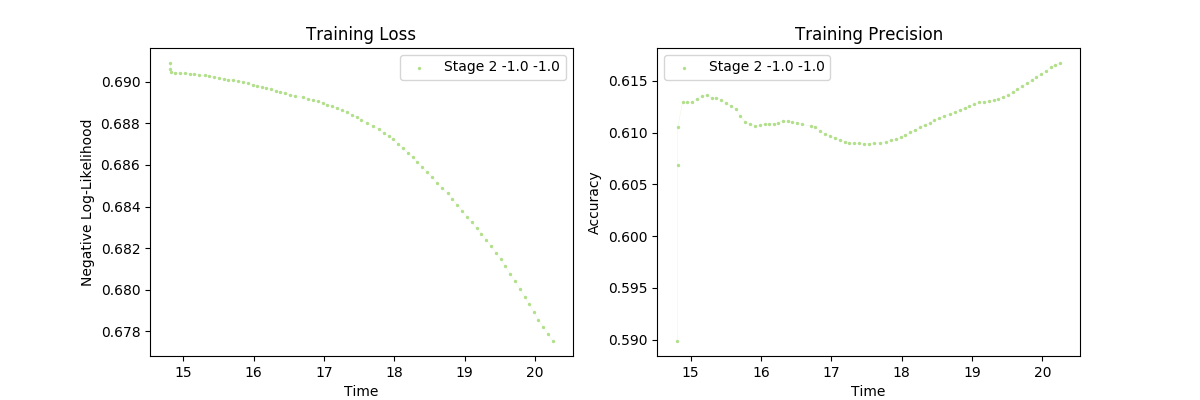

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_19-32-59/run_3",
bb loss_conv adam -1.0 0.0001 -1.0 -1.0


<IPython.core.display.Javascript object>


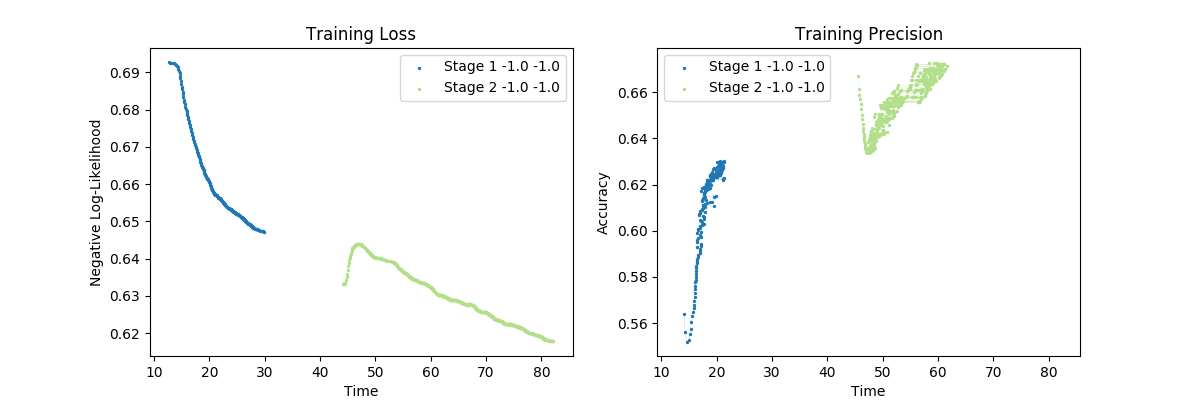

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-25-05/run_1",
bb loss_conv adam -1.0 0.01 -1.0 -1.0


<IPython.core.display.Javascript object>


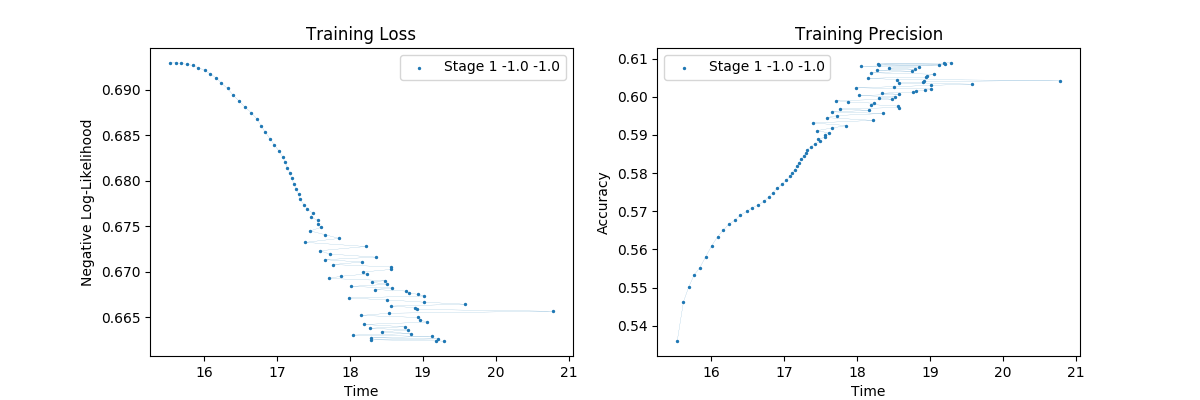

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-10-53/run_1",
bb loss_conv adam -1.0 0.01 -1.0 -1.0


<IPython.core.display.Javascript object>


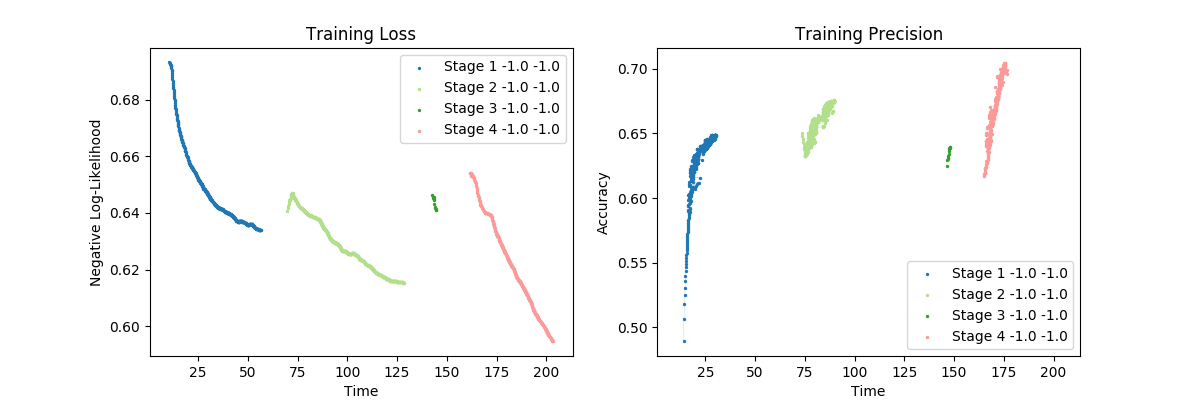

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-20-20/run_1",
bb loss_conv adam -1.0 0.01 -1.0 -1.0


<IPython.core.display.Javascript object>


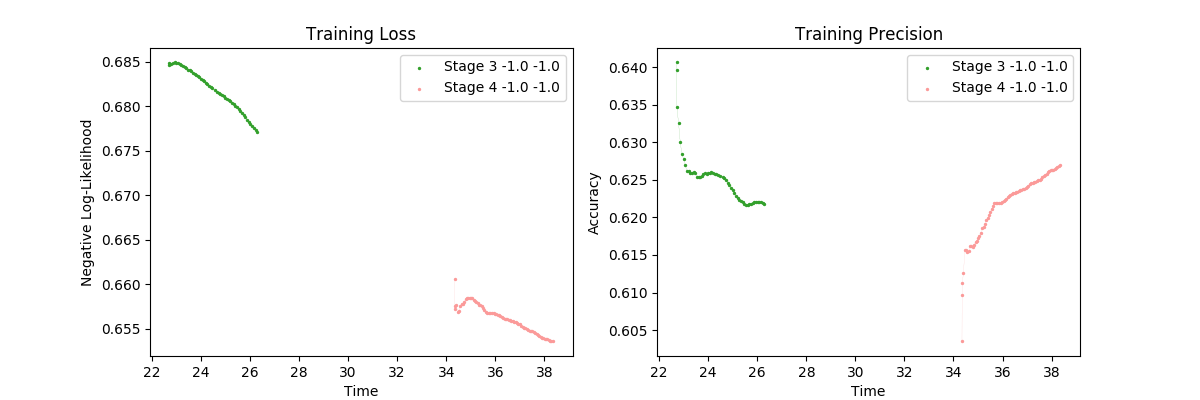

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_19-34-36/run_3",
bb loss_conv adam -1.0 0.0001 -1.0 -1.0


<IPython.core.display.Javascript object>


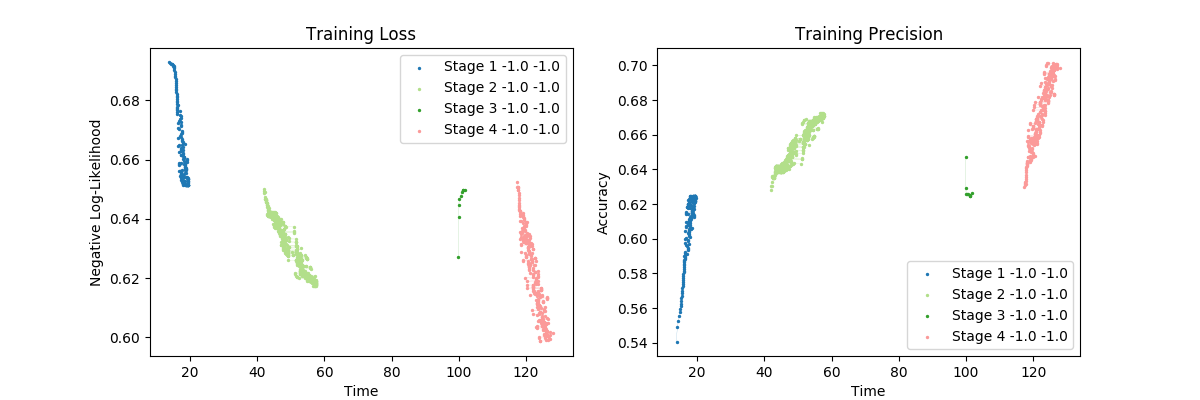

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-15-38/run_1",
bb loss_conv adam -1.0 0.01 -1.0 -1.0


<IPython.core.display.Javascript object>


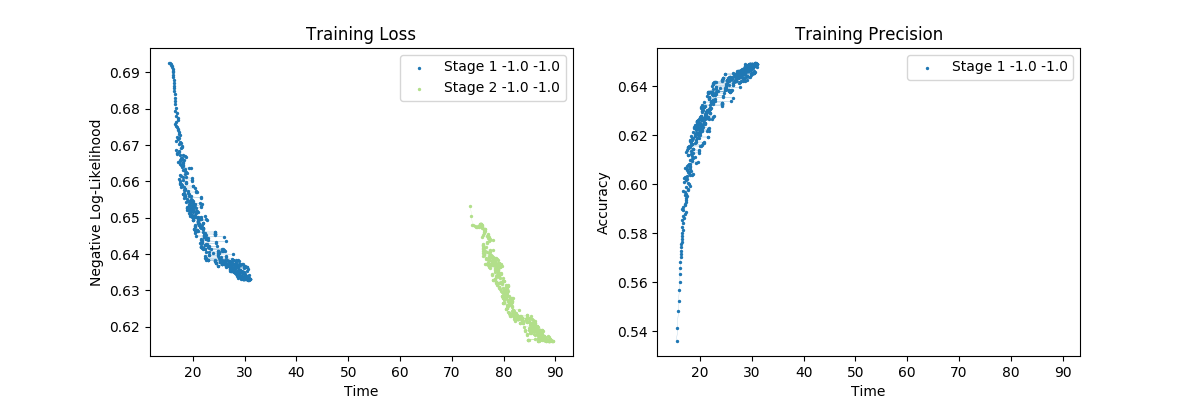

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-15-38/run_2",
bb loss_conv adam -1.0 0.001 -1.0 -1.0


<IPython.core.display.Javascript object>


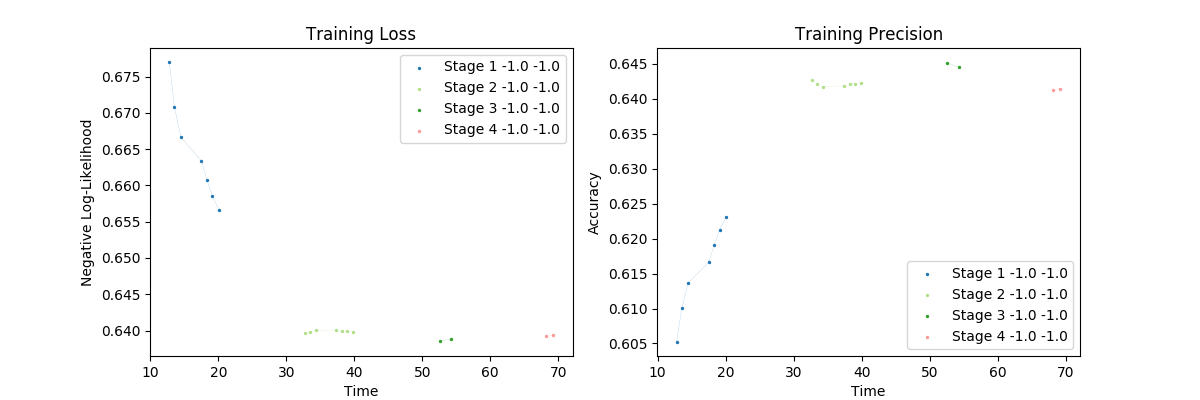

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_15-20-09/run_3",
bb loss_conv adam -1.0 0.001 -1.0 -1.0


<IPython.core.display.Javascript object>


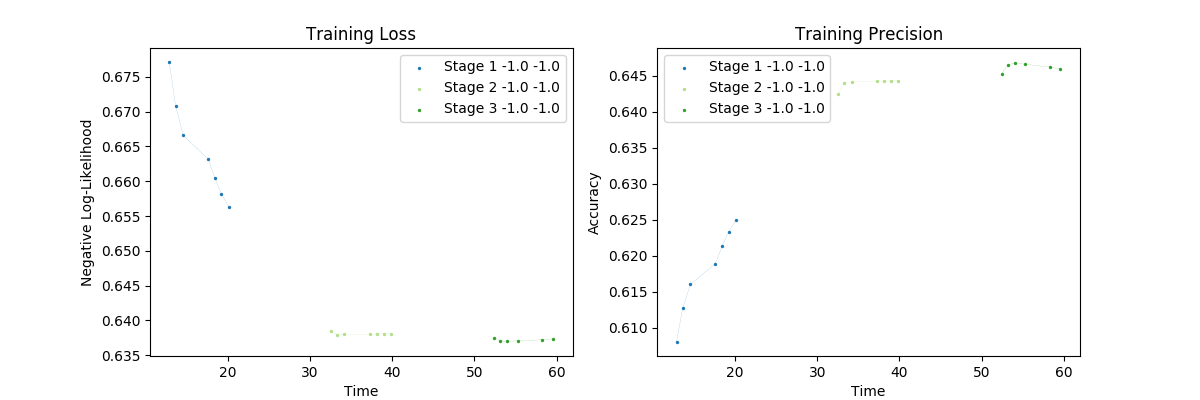

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_15-20-09/run_1",
bb loss_conv adam -1.0 1e-10 -1.0 -1.0


<IPython.core.display.Javascript object>


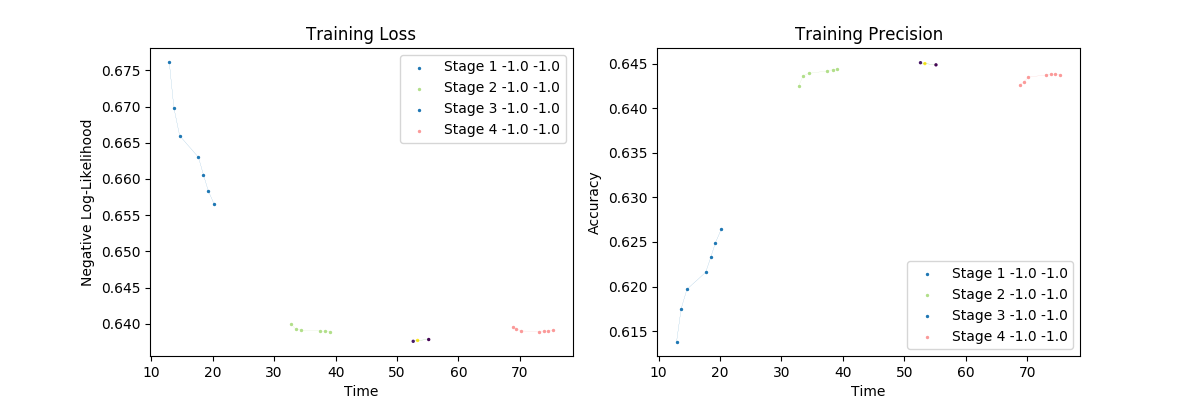

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_15-20-09/run_4",
bb loss_conv adam -1.0 0.0001 -1.0 -1.0


<IPython.core.display.Javascript object>


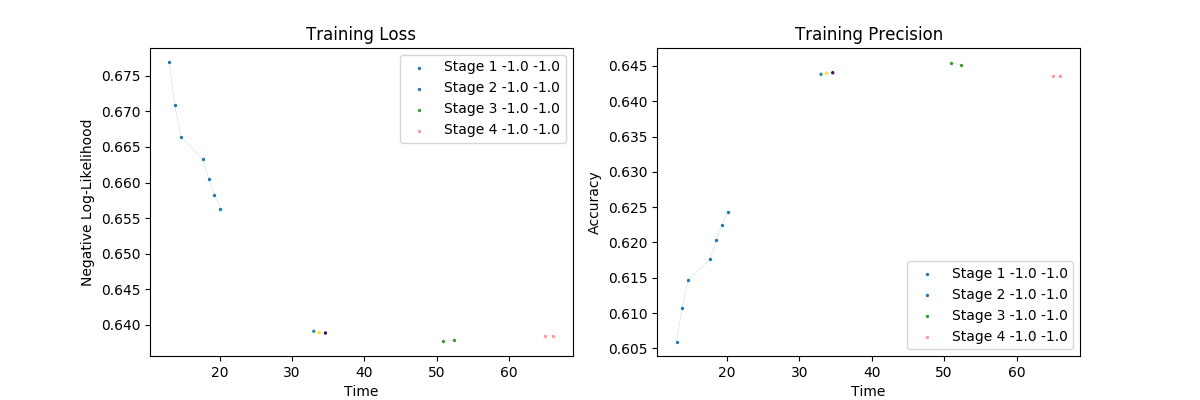

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_15-20-09/run_2",
bb loss_conv adam -1.0 0.01 -1.0 -1.0


<IPython.core.display.Javascript object>


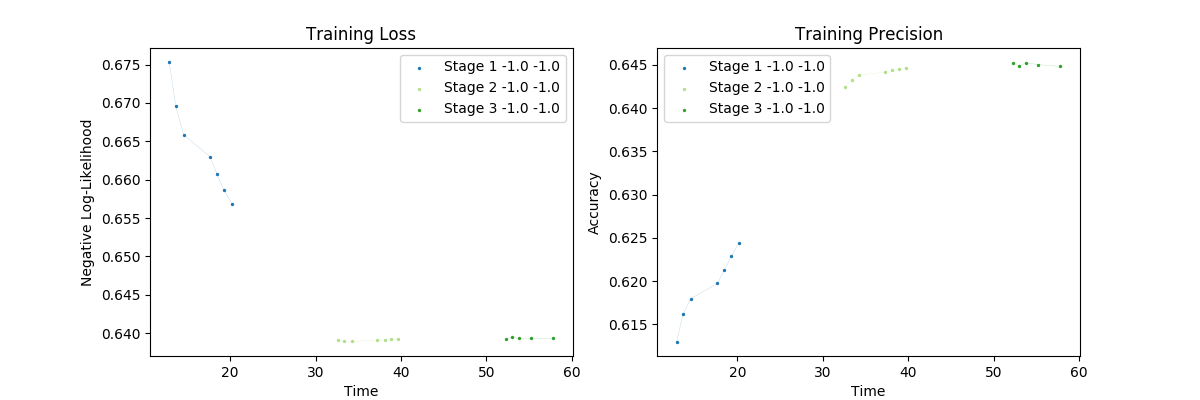

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_15-20-09/run_5",
bb loss_conv adam -1.0 1e-05 -1.0 -1.0


<IPython.core.display.Javascript object>


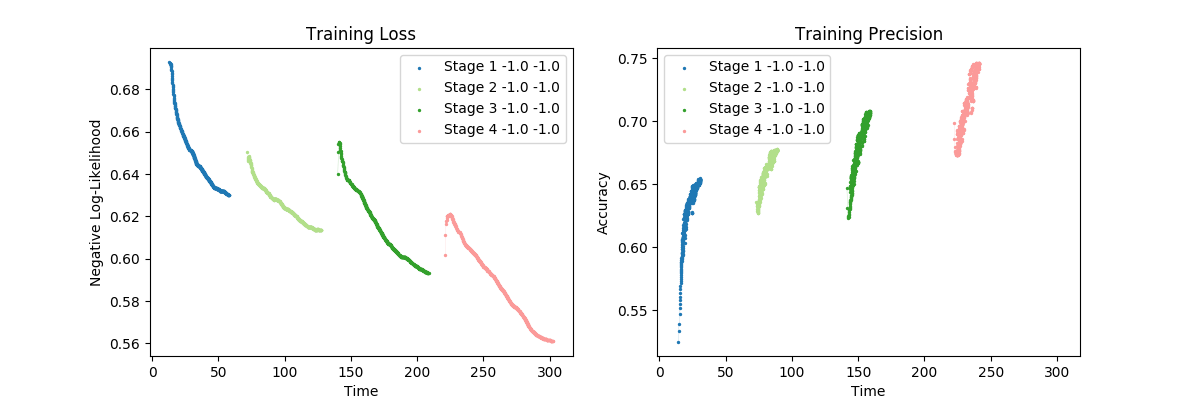

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-26-34/run_3",
bb loss_conv adam -1.0 0.0001 -1.0 -1.0


<IPython.core.display.Javascript object>


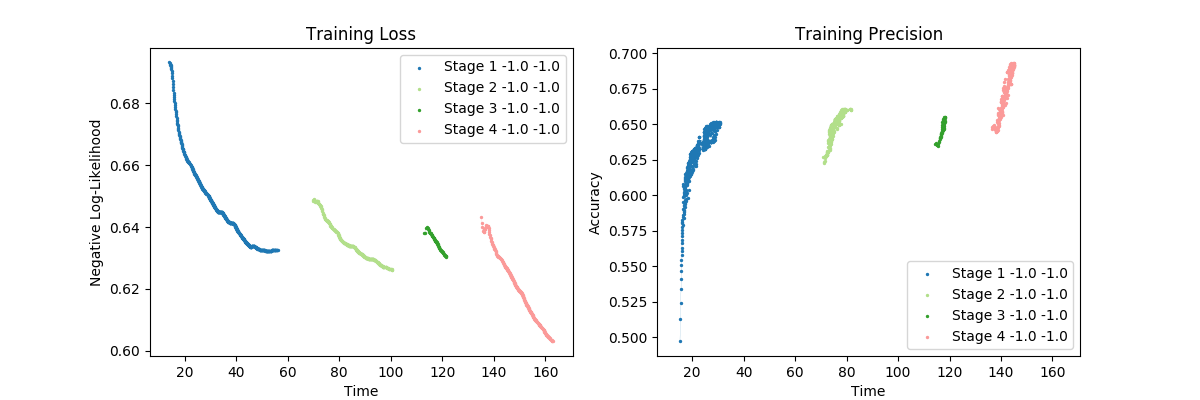

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-26-34/run_1",
bb loss_conv adam -1.0 0.01 -1.0 -1.0


<IPython.core.display.Javascript object>


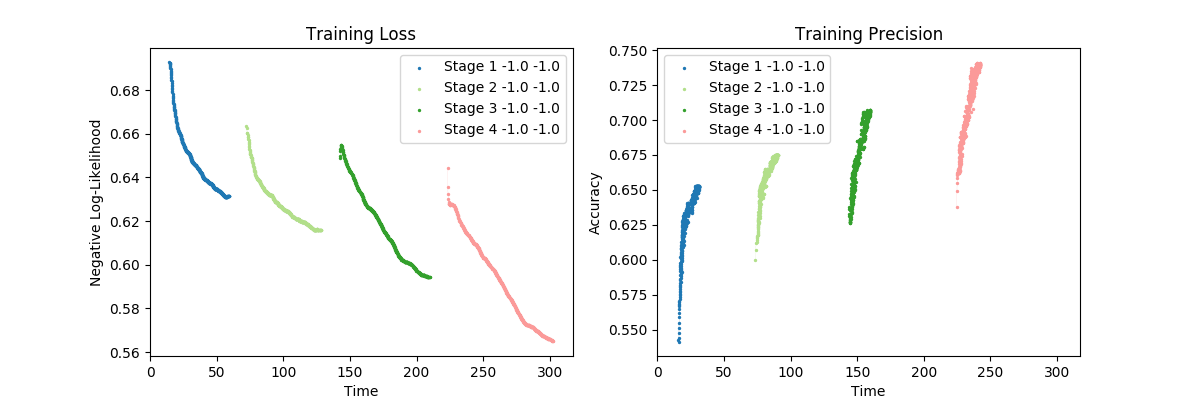

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-26-34/run_2",
bb loss_conv adam -1.0 0.001 -1.0 -1.0


<IPython.core.display.Javascript object>


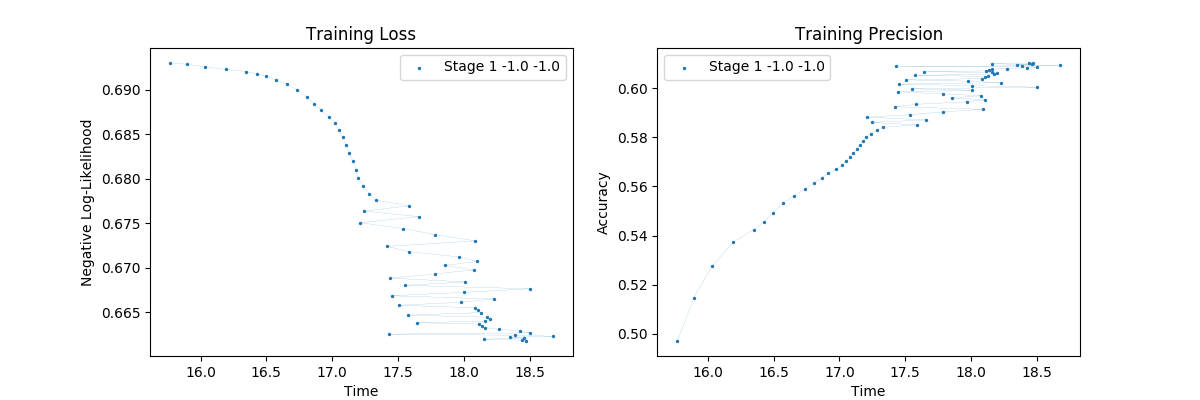

Experiment loss_conv
"/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-14-04/run_1",
bb loss_conv adam -1.0 0.01 -1.0 -1.0


In [99]:
for exp, res_all_sessions in res_all_exps.items():  
  for session, res in res_all_sessions.items():        
    for run, run_data in res.items():      

      if run_data["plot_this_run"]:
        
        fig, args, params, ts, xs, ys = plot_run(run_data)        
        figs += [fig]
                         
        data = (args.dataset, exp, session, run, args, params, ts, xs, ys)
        
        print("Experiment", exp)
        print("\"{}/{}\",".format(session, run))
        print(args.dataset, args.algo, args.opt, args.tau_ent, args.tau_loss, args.tau_mu, args.tau_sd)
        
        #         _fp = "{}/{}".format(session, run)
        #         if _fp in keep_fp:                
        #           if _fp not in keep_data[args.dataset][args.model_type][exp].keys():
        #             keep_data[args.dataset][args.model_type][exp][_fp] = data
        #             print("!!Adding to", args.dataset, args.model_type, exp)
        #           else:
        #             print("Found", _fp, "to add, but was already added!")              

# Add runs from keep_fp to data

In [137]:
for exp, res_all_sessions in res_all_exps.items():  
  for session, res in res_all_sessions.items():        
    for run, run_data in res.items():      
      
      _fp = "{}/{}".format(session, run)
      if _fp in keep_fp:                
        if _fp not in keep_data[args.dataset][args.model_type][exp].keys():
                     
          args, params, ts, xs, loss, acc = extract_data(run_data)        

          data = (args.dataset, exp, session, run, args, params, ts, xs, loss, acc)
        
          print("Experiment", exp)
          print("\"{}/{}\",".format(session, run))
          print(args.dataset, args.algo, args.opt, args.tau_ent, args.tau_loss, args.tau_mu, args.tau_sd)
                
          keep_data[args.dataset][args.model_type][exp][_fp] = data
          
          print("!!Adding to", args.dataset, args.model_type, exp)
        else:
          print("Found", _fp, "to add, but was already added!")              

Found /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-36-47/run_3 to add, but was already added!
Found /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-20-20/run_1 to add, but was already added!
Found /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-26-34/run_3 to add, but was already added!
Found /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-26-34/run_1 to add, but was already added!
Found /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/sd_div/10-12-17_21-27-06/run_5 to add, but was already added!
Found /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/sd_div/10-12-17_21-27-06/run_5 to add, but was already added!
Found /tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/loss_conv/10-12-17_21-20-20/run_1 to add, but was a

In [138]:
keep_data["bb"]["parafac"]["ent_div"].keys()

dict_keys(['/tmp/stephan/logs/multires/group2/multires_bb_200000_sw0.50_tt0.90/parafac/ent_div/10-12-17_21-36-47/run_3'])

In [139]:
# for f in figs:
#   plt.close(f)

# Paper plots

In [140]:
DS = ["bb", "fvf"]
MODEL_TYPE = ["full", "parafac"]
EXPS = []
EXPS += ["ent_div"]
EXPS += ["loss_conv"]
EXPS += ["mu_sd"]
EXPS += ["sd_div"]
EXPS += ["multires"]
EXPS += ["fixedres"]

### Plot loss: ds, model, exp/criteria

<IPython.core.display.Javascript object>


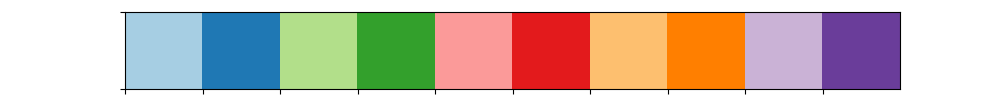

In [151]:
sns.palplot(sns.color_palette("Paired", 10))

In [156]:
# # no show lines for you ledgend
# for k,l in labels.items():
#     ax.plot([], label=l, color=colors[k], alpha=1.0)

# aggregate of runs
def plot_collection(xy_by_model):
  
    bbox = [0.15, 0.15, 0.8, 0.8]
    fig = plt.figure()
    fig.set_size_inches(6, 4)
    ax = fig.add_axes(bbox)
    
    ax.set_xlabel("Time (epochs)")
    ax.set_ylabel("Loss (NLL)")
    
    pal = sns.color_palette("Paired", 12)
    colors = {
      "fixedres": (pal[0], pal[1]),
      "loss_conv": (pal[2], pal[3]),
      "ent_div": (pal[4], pal[5]),
      "mu_sd": (pal[6], pal[7]),
      "sd_div": (pal[8], pal[9]),}
    print(colors)
    lines = []
    labels = {
      "fixedres": 'Fixed Resolution',
      "loss_conv": 'Loss Convergence',
      "ent_div": 'Entropy Divergence',
      "mu_sd": 'μ,σ-divergence',
      "sd_div": 'σ-divergence',
    }
    
    for k, xys in xy_by_model.items():  
                
        MAX_T = min([len(x) for x,y in xys])
        MIN_STEPS = 0
        MAX_STEPS = 10000000000       
        
        xs = [x[:MAX_T] for x,y in xys if x[-1] > MIN_STEPS and x[-1] < MAX_STEPS]
        ys = [y[:MAX_T] for x,y in xys if x[-1] > MIN_STEPS and x[-1] < MAX_STEPS]        

        if not ys:
            print("Not enough points!", k)
            continue

        filtered_xys = [(x,y) for x,y in zip(xs,ys)]

        lens_x = [len(x) for x in xs]
        
        T = min(lens_x)
        idx = lens_x.index(T)
        x = xs[idx][:T]

        all_xs, all_ys, min_ys, max_ys, avg_ys = interleave(filtered_xys)        

        ax.fill_between(all_xs, min_ys, max_ys, edgecolor=None, facecolor=colors[k][0], interpolate=True, lw=1)                
        line = ax.plot(all_xs, avg_ys, color=colors[k][1], lw=3, label=labels[k])
        lines += [line]
    plt.legend()
    return fig 

<IPython.core.display.Javascript object>


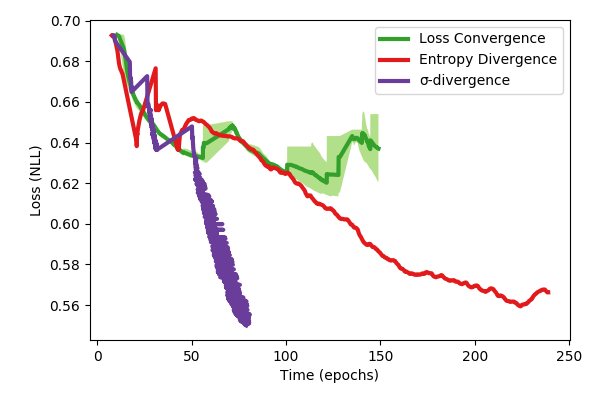

{'fixedres': ((0.65098039215686276, 0.80784313725490198, 0.8901960784313725), (0.12156862745098039, 0.47058823529411764, 0.70588235294117652)), 'loss_conv': ((0.69803921568627447, 0.87450980392156863, 0.54117647058823526), (0.20000000000000001, 0.62745098039215685, 0.17254901960784313)), 'ent_div': ((0.98431372549019602, 0.60392156862745094, 0.59999999999999998), (0.8901960784313725, 0.10196078431372549, 0.10980392156862745)), 'mu_sd': ((0.99215686274509807, 0.74901960784313726, 0.43529411764705883), (1.0, 0.49803921568627452, 0.0)), 'sd_div': ((0.792156862745098, 0.69803921568627447, 0.83921568627450982), (0.41568627450980394, 0.23921568627450981, 0.60392156862745094))}


In [160]:
DS = "bb"
MODEL_TYPE = "parafac"

xy_by_model = defaultdict(lambda:[])

for exp in ["fixedres", "loss_conv", "ent_div", "mu_sd", "sd_div"]:
  for fp,data in keep_data["bb"]["parafac"][exp].items():
    # print(fp)  
    
    dataset, exp, session, run, args, params, ts, xs, loss, acc = data  
    #     print(ts.keys())
    #     print(ys.keys())
    _ts = []
    _ys = []
    for stage in ts.keys():
      _ts += ts[stage]
      _ys += loss[stage]
    #     print(min(_ts), max(_ts))
    #     print(min(_ys), max(_ys))
    xy_by_model[exp] += [(_ts, _ys)]

fig = plot_collection(xy_by_model)
fig.savefig("/home/stzheng/projects/multi-resolution-tensor-training/paper/images/sensitivity-{}-{}.pdf".format(DS,MODEL_TYPE), bbox_inches='tight')